## Sample Signal

In [ ]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
TRAIN_PATH = '../data/'
ipd.Audio(TRAIN_PATH + "man_voice.wav")

In [6]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "man_voice.wav")
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 11025Hz
Audio duration: 2.00562358276644s


In [10]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    print("audio : ", audio)
    return audio

audio :  [0.55895197 0.55895197 0.55895197 ... 0.55895197 0.55895197 0.55895197]


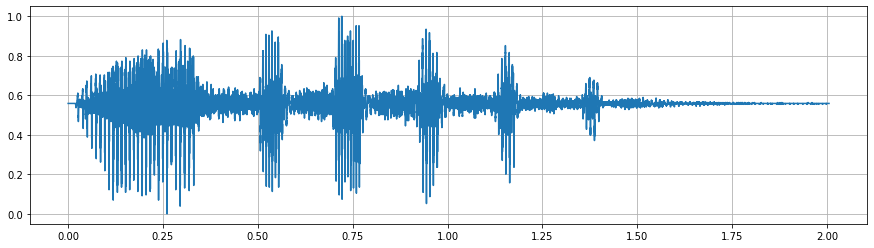

In [106]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

## Audio Framing

In [47]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [122]:
hop_size = 15 #ms
FFT_size = 1024

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("sample rate : ", sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

sample rate :  11025
Framed audio shape: (135, 1024)


In [123]:
print("First frame:")
audio_framed[1]

First frame:


array([0.5720524 , 0.57641921, 0.57641921, ..., 0.68995633, 0.69868996,
       0.69432314])

In [149]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([0.55895197, 0.55895197, 0.55895197, ..., 0.55895197, 0.55895197,
       0.55895197])

## Convert to frequency domain

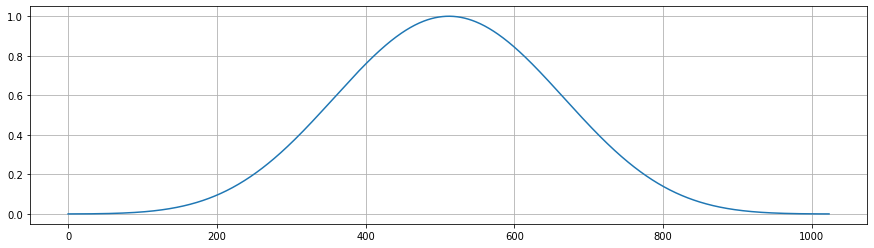

In [125]:
window = get_window("blackmanharris", FFT_size, fftbins=True) #blackman, hamming, hann, gaussian, ...
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

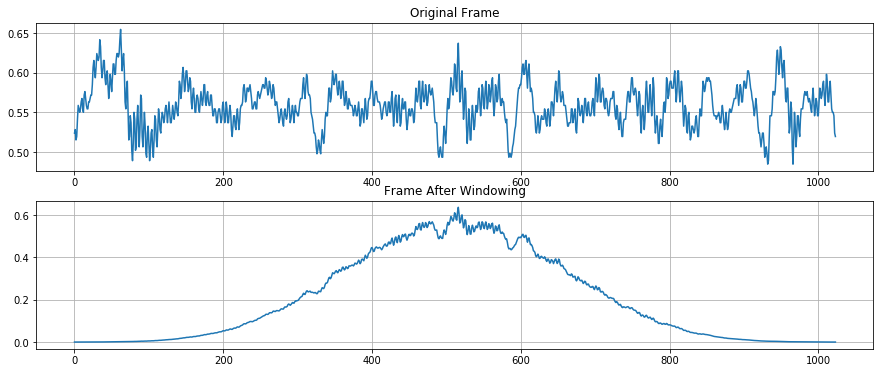

In [126]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [127]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

## Calculate signal power

In [128]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(135, 513)


## MEL-spaced filterbank

In [129]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10
print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 5512.5


In [130]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [131]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
   
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [132]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate)
filter_points

MEL min: 0.0
MEL max: 2460.4968986819067


array([  0,  14,  31,  52,  78, 110, 149, 196, 253, 323, 408, 512])

## Construct the filterbank

In [133]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

filter points :  [  0  14  31  52  78 110 149 196 253 323 408 512]
filters :  [[0.         0.07692308 0.15384615 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00970874 0.         0.        ]]


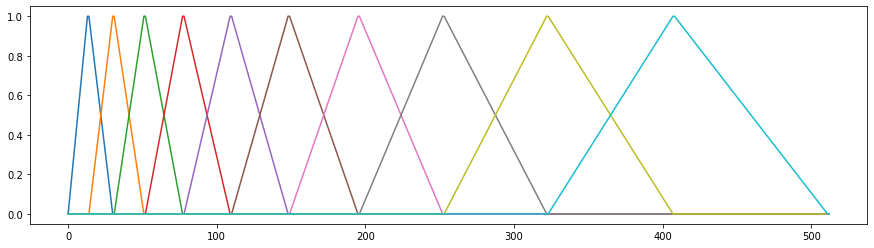

In [134]:
filters = get_filters(filter_points, FFT_size)
print("filter points : ", filter_points)
print("filters : ", filters)
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [135]:
# taken from the LibROSA library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
print("1 : ", mel_freqs[2:mel_filter_num+2])
print("2 : ", mel_freqs[:mel_filter_num])
print("enorm : ", enorm)
print("mel freqs size : ", mel_freqs.shape)
filters *= enorm[:, np.newaxis]

1 :  [ 341.09961914  569.66577047  848.41202424 1188.35507153 1602.93024101
 2108.52249396 2725.11399546 3477.07385543 4394.12125168 5512.5       ]
2 :  [   0.          153.68011187  341.09961914  569.66577047  848.41202424
 1188.35507153 1602.93024101 2108.52249396 2725.11399546 3477.07385543]
enorm :  [0.00586339 0.00480786 0.00394234 0.00323264 0.0026507  0.00217352
 0.00178224 0.0014614  0.00119832 0.0009826 ]
mel freqs size :  (12,)


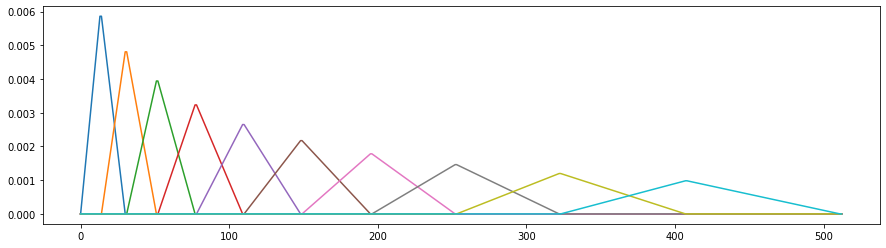

In [136]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

## Filter the signal

In [137]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 135)

## Generate the Cepstral Coefficients

In [138]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [139]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 135)

In [144]:
cepstral_coefficents[:, 0]

array([-1.28513595e+02,  4.46171326e+01,  2.89732828e+01,  2.51039125e+01,
        6.21320652e+00,  7.53754953e+00,  7.86279645e+00,  5.37797135e+00,
        4.60806940e+00,  4.43704458e+00,  2.22088602e-13, -4.43704458e+00,
       -4.60806940e+00, -5.37797135e+00, -7.86279645e+00, -7.53754953e+00,
       -6.21320652e+00, -2.51039125e+01, -2.89732828e+01, -4.46171326e+01,
        1.81745669e+02, -4.46171326e+01, -2.89732828e+01, -2.51039125e+01,
       -6.21320652e+00, -7.53754953e+00, -7.86279645e+00, -5.37797135e+00,
       -4.60806940e+00, -4.43704458e+00, -9.06951308e-14,  4.43704458e+00,
        4.60806940e+00,  5.37797135e+00,  7.86279645e+00,  7.53754953e+00,
        6.21320652e+00,  2.51039125e+01,  2.89732828e+01,  4.46171326e+01])

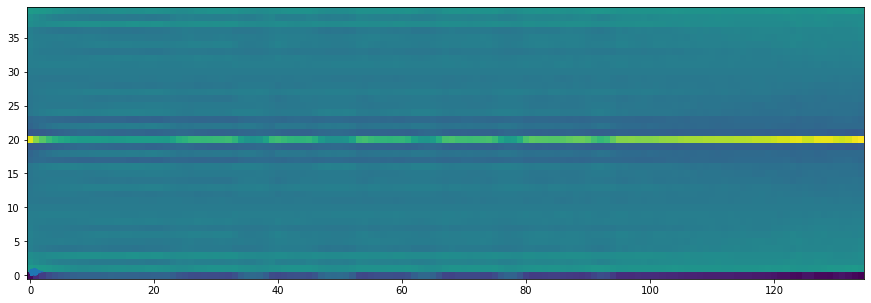

In [141]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');